In [203]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [204]:
df = pd.read_csv('..\data\imputed_dataset.csv')
df.head()

,rating,ranking,year,position,height,weight,latitude,longitude,state_province,stars,committed_to,is_drafted,conference,latitude_school,longitude_school,distance_miles,side_of_ball,position_group
0,0.9992,1.0,2015,DT,74.0,313.0,31.578206,-84.155681,GA,5,Georgia,0.0,SEC,33.94982,-83.373381,170.049603,defense,d_line
1,0.9991,1.0,2015,DT,74.5,313.0,31.578206,-84.155681,GA,5,Georgia,0.0,SEC,33.94982,-83.373381,170.049603,defense,d_line
2,0.9879,27.0,2015,ATH,72.0,168.0,33.173177,-84.914936,GA,5,Georgia,1.0,SEC,33.94982,-83.373381,103.714733,athlete,athlete
3,0.9769,48.0,2015,OLB,74.0,207.0,32.305158,-84.027407,GA,4,Georgia,1.0,SEC,33.94982,-83.373381,119.771399,defense,linebacker
4,0.9680,65.0,2015,SDE,76.0,265.0,33.853270,-84.220073,GA,4,Georgia,0.0,SEC,33.94982,-83.373381,49.011958,defense,d_line


In [205]:
print(f"Percent of all players drafted: {round(len(df[df['is_drafted'] == 1.0]) / len(df) * 100, 2)}%")

Percent of all players drafted: 5.22%


In [206]:
len(df[df['is_drafted'] == 1.0])

1190

In [207]:
# Define numerical and categorical values
numerical_features = ['rating', 'ranking', 'height', 'weight', 'distance_miles', 'stars']
categorical_features = ['side_of_ball', 'position_group']
target = ['is_drafted']


In [208]:
# Features and target
X = df[numerical_features+categorical_features]
y = df[target]

In [209]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),
    ('classifier', DBSCAN())
])

In [210]:
clusters = pipe.fit_predict(X)
pca_data = pipe.named_steps['pca'].fit_transform(preprocessor.fit_transform(X))
df['cluster'] = clusters

In [211]:
cluster_summary = df.groupby('cluster')['is_drafted'].agg(['sum', 'count'])
cluster_summary['proportion_drafted'] = cluster_summary['sum'] / cluster_summary['count']
cluster_summary = cluster_summary.sort_values('proportion_drafted', ascending=False)
cluster_summary

,sum,count,proportion_drafted
cluster,,,
0,108.0,309,0.349515
1,383.0,3184,0.120289
-1,1.0,13,0.076923
2,696.0,19211,0.036229
3,2.0,56,0.035714
4,0.0,11,0.000000


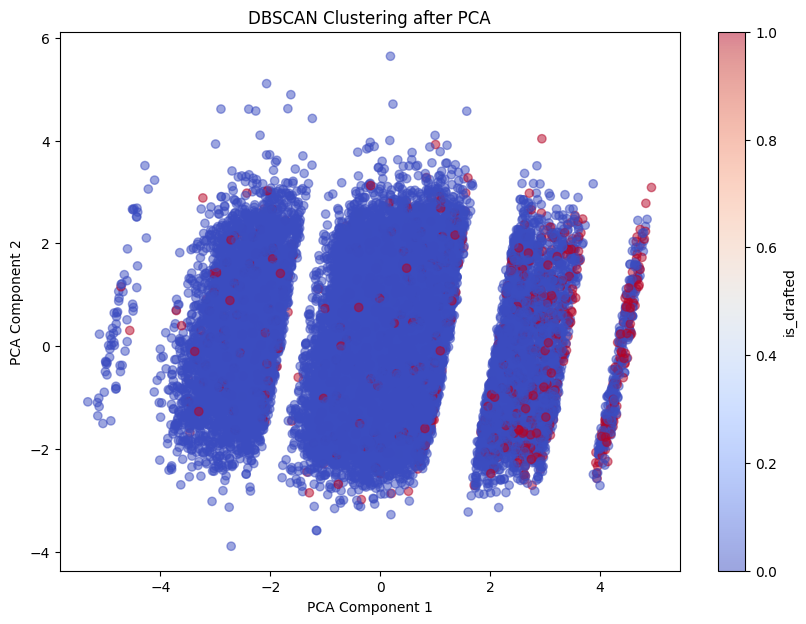

In [243]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=df['is_drafted'], cmap='coolwarm', alpha=0.5)
plt.colorbar(label='is_drafted')
plt.title('DBSCAN Clustering after PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()